**Aman Oberoi
St125490**

In [1]:
import numpy as np
import pandas as pd
import os
import mlflow
from mlflow import MlflowClient
#tried to trun the auto long off
mlflow.autolog(disable=True)
pd.set_option('compute.use_numexpr', True)

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
import missingno as msno 

from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from cf_matrix import make_confusion_matrix

from Models.Logistic_regression import LogisticRegression
#all the imports


import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th")
#while deployment change the name from qb
# os.environ["LOGNAME"] = "qb"

In [3]:
x_data = pd.read_csv('./data/Cars.csv')
x_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
# x_data['owner']=x_data['owner'].astype('category')
x_data['seller_type'].value_counts()

seller_type
Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: count, dtype: int64

**Tried to combine Dealer and Truestmaker Dealer as group**

In [5]:
x_data['owner'].loc[x_data[(x_data['owner'] == 'Fourth & Above Owner') | (x_data['owner'] == 'Third Owner')].index] = 'others'

In [6]:
#few operations
#remove the rows with CNG and Petrol because of diffenece in units
x_data.drop(x_data[(x_data['fuel'] == 'CNG') | (x_data['fuel'] == 'LPG')].index, inplace=True)
x_data['mileage']=x_data['mileage'].apply(lambda x: str(x).split()[0]).astype('float')
x_data['engine'] = x_data['engine'].apply(lambda x: str(x).split()[0]).astype('float')

#remove the torque
x_data.drop(columns = {'torque'}, inplace=True)
# remove the test drive owners
x_data.drop(x_data[x_data['owner']=='Test Drive Car'].index, inplace=True)
x_data['company'] = x_data['name'].apply(lambda x:  x.split()[0])

x_data['max_power']= x_data['max_power'].apply(lambda x: str(x).split()[0])
x_data['max_power'] = x_data['max_power'].replace('bhp', np.NAN).astype('float')

<Axes: xlabel='count', ylabel='name'>

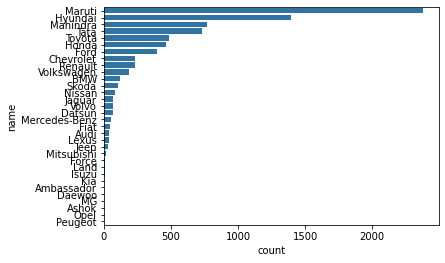

In [7]:
#the number of companies car sold in total 
#this could be a feature to explain the future trajectory in the data
c_per_company =x_data['name'].apply(lambda x:x.split()[0]).value_counts()
sns.barplot(data = c_per_company.to_frame().reset_index(), x = 'count', y = 'name')
# sns.barplot(data = c_per_company.reset_index(name='count').rename(columns = {'index':'names'}), x = 'count', y = 'names')


**Number of indivisual cars sold by the companies, though this is just and Explaination of Data might not condiser as feature**

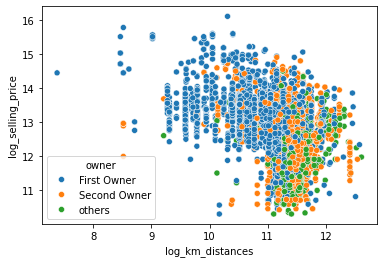

In [8]:
x_data['km_distances']=x_data.groupby(['company','year','owner'])['km_driven'].transform(lambda x:  x.mean())

x_data['log_selling_price'] = x_data['selling_price'].transform('log')
x_data['log_km_distances'] = x_data['km_distances'].transform('log')
sns.scatterplot(data = x_data, x = 'log_km_distances', y = 'log_selling_price', hue="owner")

x_data.drop(columns = {'log_selling_price', 'log_km_distances'}, inplace=True)
#(np.log(x_data['selling_price']), np.log(x_data['km_distances']), hue='owner')

**As the more the car is driven, the lesser the price**

In [9]:
#the specific company is almost null
x_data.drop(6730, inplace=True)

**Droping the row 6730 as it is almost misisng**

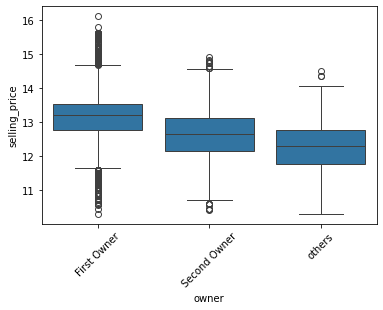

In [10]:
ax=sns.boxplot(data = x_data, x = 'owner', y = x_data['selling_price'].transform('log'))
v=ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<span style = 'color:black'>**The First Owner has the considerable effect on the selling price owners with lesser driven and are from specific category of owner has the effect.**</span>

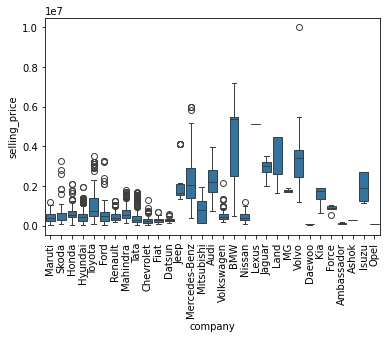

In [11]:
ax=sns.boxplot(data = x_data,x = 'company', y = 'selling_price')
v=ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

<Axes: xlabel='company', ylabel='year'>

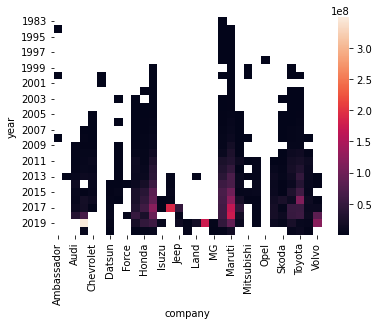

In [12]:
b = x_data[['company', 'year', 'selling_price']].groupby(['company', 'year'])['selling_price'].apply(lambda x: x.sum())
b=b.reset_index()
sns.heatmap(b.pivot(columns = 'company', index = 'year', values = 'selling_price'))
#for example the maruti company have less selling price in 1983 than in 2020 but at the same time maruti have shown in the number of selling price

**Maruti has very less variation in selling price, yet is the most sold car accross the year, so the selling of maruti car is constant because of the range of price is not varying with the given data. At the same time BMW has the sqwness in bounding box feature sample is very less**

In [13]:
#average sale of the company per year 
r=x_data.groupby(['company', 'year'])['name'].apply(lambda x:x.count()).reset_index()

r.set_index('year', inplace=True)
#r[r['company'] == 'Maruti']['name'].plot()
#x_data['company'].unique().shape
company_name = []
n_ = r['company'].value_counts().reset_index()
for k,i in n_.iterrows():
    if i['count'] > 6:
        company_name.append(i['company'])
Company_name = widgets.Dropdown(options= company_name, value=None, description='Company Name:')
def vol_plt(Company_name):
    df2 = r.copy()
    df2 = df2[df2.company == Company_name]
    if len(df2) > 0:
        #pv_df =x.pivot(index='time_id', columns='stock_id', values='target')
        df2.plot()
        plt.show()

interactive(vol_plt,Company_name=Company_name)

interactive(children=(Dropdown(description='Company Name:', options=('Maruti', 'Mahindra', 'Hyundai', 'Tata', …

**pre company car soled select the drop box**

In [14]:
# r = x_data[(x_data['company'] == 'Maruti') & (x_data['year'] == 2014)]
# r[['company', 'name', 'year', 'selling_price']].groupby(['name', 'year'])['selling_price'].apply(lambda x: x.sum())

In [15]:
#log transfrom of training data
# x_data['selling_price'] = x_data['selling_price'].transform('log')

In [16]:
lb= OrdinalEncoder()
t = lb.fit(x_data['transmission'].values.reshape(-1,1))
# with open('transmission.pickle', 'wb') as f:
#     pickle.dump(t, f)

In [17]:
lb= OneHotEncoder()
f = lb.fit(x_data['fuel'].values.reshape(-1, 1))
# with open('fuel.pickle', 'wb') as f_:
#     pickle.dump(f, f_)

In [18]:
lb= OrdinalEncoder()
o = lb.fit(x_data['company'].values.reshape(-1,1))
# with open('company.pickle', 'wb') as f:
#     pickle.dump(o, f)

In [19]:
lb = OneHotEncoder()
b = lb.fit(x_data['owner'].values.reshape(-1, 1))
# with open('owner.pickle', 'wb') as f:
#     pickle.dump(b, f)

In [20]:
lb = OrdinalEncoder()
b_ = lb.fit(x_data['owner'].values.reshape(-1, 1))
# with open('owner_ordinal.pickle', 'wb') as f:
#     pickle.dump(b, f)

**Few embedding done**

**<span style="color:blue">Binning Classes</span>**

In [21]:
import more_itertools
x_data['binned_selling_price'] = 0
quantiles = [x_data['selling_price'].quantile(0), x_data['selling_price'].quantile(0.25), x_data['selling_price'].quantile(0.50), x_data['selling_price'].quantile(0.75), x_data['selling_price'].quantile(1.)]
quantiles =list(more_itertools.windowed(quantiles,2))
index_ = x_data.index.to_list()
res = {'c':[], 'index':[]}
def cut_bin(x, quant):
    for i,q in enumerate(quantiles):
        if i != 3:
            idx=x['selling_price'][(x['selling_price'] >= quantiles[i][0]) & (x['selling_price'] <= quantiles[i][1]-10)].index
        else:
            idx=x['selling_price'][(x['selling_price'] >= quantiles[i][0]) & (x['selling_price'] <= quantiles[i][1])].index

        if idx.any():
            #x_data['binned_selling_price'] = n 
            res['c'].append(np.repeat(i, idx.shape[0]))
            res['index'].append(idx)
x_data.groupby('company')[['selling_price','binned_selling_price']].apply(lambda x: cut_bin(x, quantiles))

""


In [22]:
x_data['binned_selling_price']=pd.DataFrame({
    'class':np.apply_along_axis(np.hstack,arr=res['c'],axis=0)},
        index = np.apply_along_axis(np.hstack, arr=res['index'], axis=0))

In [23]:
df1 = x_data.pivot_table(index = 'company', columns = 'binned_selling_price', values = 'selling_price', aggfunc = np.mean)

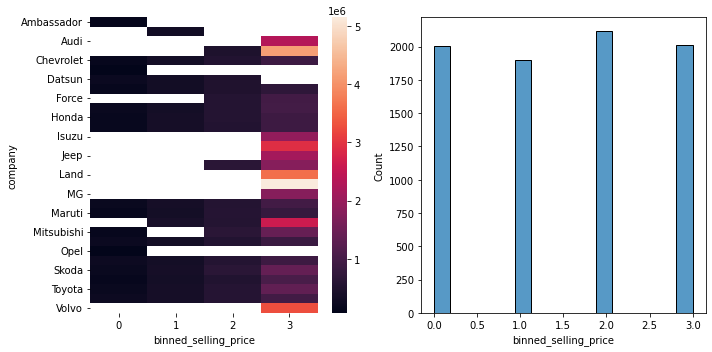

In [24]:
fig,ax =plt.subplots(1,2, figsize=(10,5))
ax=ax.flatten()
sns.heatmap(df1, ax=ax[0])
sns.histplot(x_data['binned_selling_price'], ax=ax[1])
plt.tight_layout()

**Binned distribution, each class like 0 and 2 has lower range of selling_price accross the cars distribution model.We did it this way inorder to reduce the bin bias and and out of sample classes if we split(ie train, test or validation) and bin**

**Early test train split at unifrom random**

In [25]:
#split the training and testing data before hand
x_data['index'] = x_data.index
# test = x_data.loc[round(x_data.shape[0]-x_data.shape[0]*0.20):x_data.shape[0]]
# train = x_data.loc[0:round(x_data.shape[0]-x_data.shape[0]*0.20) - 1]
state = round(np.random.uniform(100))
train, test, y_train, y_test = train_test_split(x_data, x_data['selling_price'], test_size=0.20, random_state= state)


In [26]:
train.shape, y_train.shape

((6421, 16), (6421,))

In [27]:
number_sold = train.groupby(['company'])['name'].apply(lambda  x: x.value_counts()).to_frame().reset_index().rename(columns = {'level_1':'name', 'name':'number_sold'})
train = pd.merge(number_sold, train, on = ['company', 'name'], how = 'right')

number_sold = test.groupby(['company'])['name'].apply(lambda  x: x.value_counts()).to_frame().reset_index().rename(columns = {'level_1':'name', 'name':'number_sold'})
test = pd.merge(number_sold, test, on = ['company', 'name'], how = 'right')


**Let us see the impact of numbers of vayring car sold each year by the each company**

<Axes: title={'center': 'Maruti Ritz VDi'}, xlabel='year'>

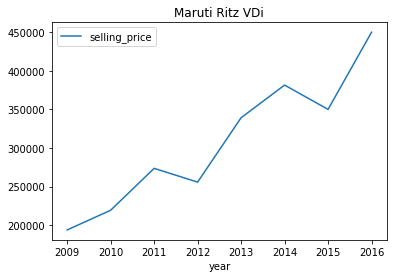

In [28]:
#because of short of time could make interactive plots
r2 = train.groupby(['company', 'name','year'])['selling_price'].apply(lambda x:x.mean()).reset_index()
r2[(r2['company'] == 'Maruti') & (r2['name'] == 'Maruti Ritz VDi')][['year','selling_price']].set_index('year').plot(title = 'Maruti Ritz VDi')

<Axes: >

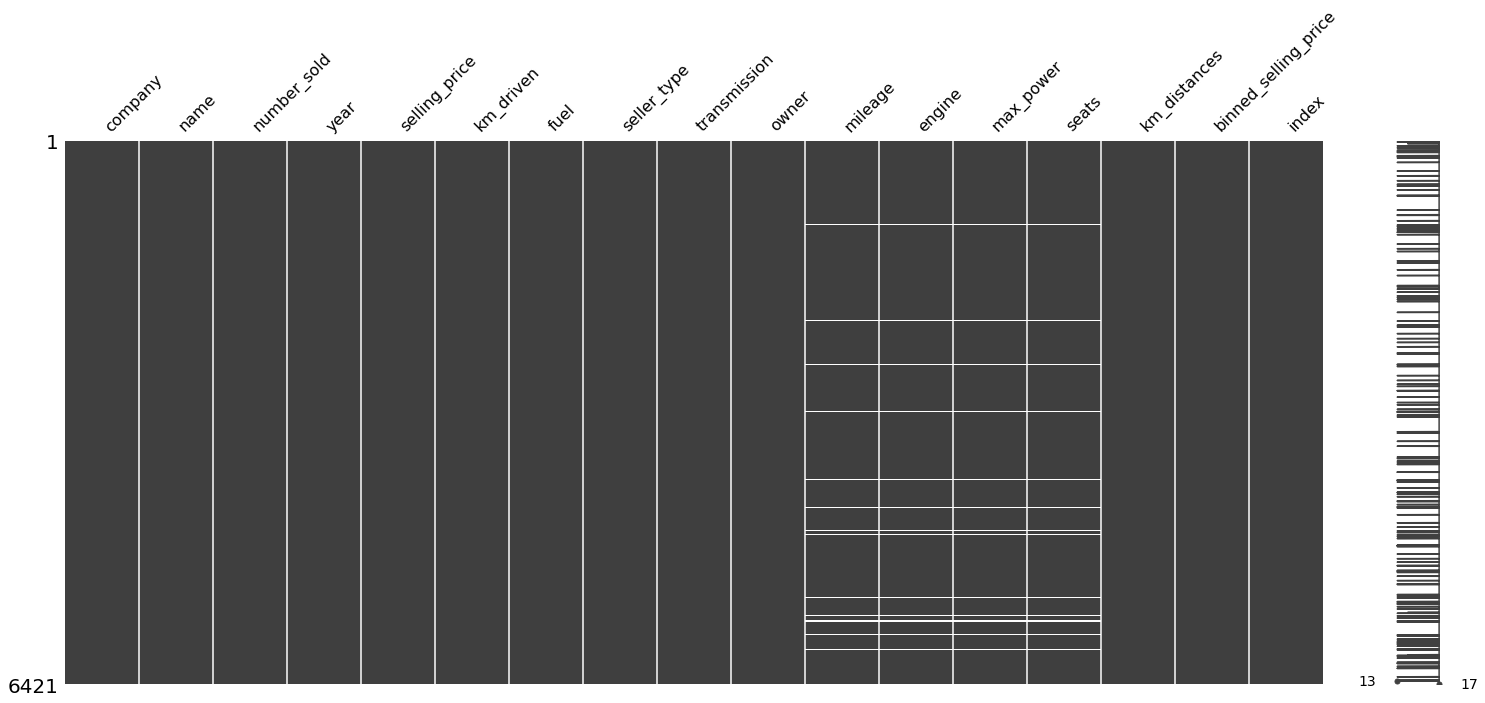

In [29]:
msno.matrix(train)

**The missingness looks like not missing at random. The missing data might have some pattren by some covariates 
or eaxtral causal impact, which out of the scope of this notebook, we did some basic imputation**

In [30]:
def imputation_d(x):
    if x.shape[0] > 0:            
        x['engine']=x['engine'].apply(lambda x: str(x).split()[0]).astype('float')
        x['index'] = x.index
        r=x.groupby('company')['engine'].apply(lambda x: x.fillna(x.median()))
        x.set_index(['company', 'index'], inplace=True)
        x['engine'] = r
        x.reset_index(inplace=True)
        
        #even though the full distribution is centered to mean but so mean is close to median , 
        #but here filling up each distribution with median as per the company
        # filling missing values for milage
        x['index'] = x.index
        r = x.groupby('company')['mileage'].apply(lambda x: x.fillna(x.mean()))
        x.set_index(['company', 'index'], inplace=True)
        x['mileage'] = r
        x.reset_index(inplace=True)
        
        x['binned_engine']=pd.cut(x['engine'], [1, 1000, 1500, 1800, x['engine'].max()], labels = list(range(1,5))[::-1])
        #drop all the na columns
        x.drop(x[x['binned_engine'].isna()].index, inplace=True)
        x['binned_engine'] = x.binned_engine.astype('int')
        
        #the distribution of max_power is not mean centered as whole so each group will be assumed (because the data is MNAR) to have median of each 
        #maxpower engine produced by companies
        x['index'] = x.index
        r = x.groupby('company')['max_power'].apply(lambda x: x.fillna(x.mean()))
        x.set_index(['company', 'index'], inplace=True)
        x['max_power'] = r
        x.reset_index(inplace=True)
        
        # seat is not the ordinal data if that so enconding required
        # filling na values by filling in with a company not sure if this make sense 
        ix=x[x['seats'].isna()].index
        for i in ix:
            name =x.loc[i]['company']
            min_seats = x[x['company'] == name]['seats'].min()
            max_seats = x[x['company'] == name]['seats'].max()
            if not pd.isna(min_seats):
                x['seats'].loc[i]=round(max_seats/min_seats) 
        return x

In [31]:
train = imputation_d(train)
test = imputation_d(test)

<Axes: xlabel='binned_engine', ylabel='count'>

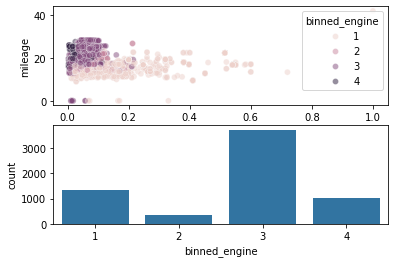

In [32]:
#binning
fig, ax=plt.subplots(2)
sns.scatterplot(ax = ax[0],data = train , x ='selling_price', y= 'mileage', hue = 'binned_engine', alpha=0.5)
bin_counts = train['binned_engine'].value_counts().reset_index()
sns.barplot(ax = ax[1], data = bin_counts, x= 'binned_engine', y = 'count')


**Engine can be considered as ordinal data, because the better the engine by cc is the higher the price, we tries to perform ordinal linear encoding by binning the ranges of engines per cc**

In [33]:
def features(x, encoding='one_hot', phase='Traning', required_unscale = True):
    #x['avg_yearly'] = x.groupby(['company','year'])['selling_price'].transform('mean')
    x['co_cc']=x.groupby(['company'])['year'].transform(lambda x: sum(x-x.min())).astype('float')
    x['_num_sales'] = x.groupby(['company', 'year'])['name'].transform('count')
    r=x.groupby(['company', 'year'])['name'].apply(lambda x:x.count()).reset_index() 
        
    x['transmission'] = pd.Series(t.transform(x['transmission'].values.reshape(-1,1)).astype('int').flatten())
    
    m = f.transform(np.array(x['fuel']).reshape(-1,1)).toarray()
    x[['Diesel','petrol']] = pd.DataFrame.from_records(m , columns = x['fuel'].unique())

    if encoding == 'one_hot':
        m = b.transform(np.array(x['owner']).reshape(-1,1)).toarray()
        x[['firstowner', 'secondowner', 'others']] = pd.DataFrame.from_records(m, columns = x['owner'].unique())
    elif encoding == 'oridinal':
        x['_owner_encoded'] = pd.Series(b_.transform(x['owner'].values.reshape(-1,1)).astype('int').flatten())
#     x['_owner_encoded']=x.groupby('company')['_owner_encoded'].transform(lambda x: x/x.max())
    
    x['_company'] = o.transform(x['company'].values.reshape(-1,1)).astype('int')

    r = x.groupby(['company', 'year'])['seats'].value_counts()
    x.set_index(['company', 'year', 'seats'], inplace = True)
    x['_seats_in_year'] = r
    x.reset_index(inplace=True)
    
    r = x.groupby(['company', 'seller_type'])['selling_price'].apply(np.mean)
    x.set_index(['company', 'seller_type'], inplace=True)
    x['avg_sellertype'] = r
    x.reset_index(inplace=True)
    
###scaling features
    x['km_distances']=x.groupby(['company', 'year','owner'])['km_driven'].transform(lambda x: x.mean())
    x['km_distances'] = x['km_distances'].transform('log')
    
    global s_, s_p
    fs = ['km_distances', 'avg_sellertype', 'max_power','selling_price', 'mileage', 'engine', '_num_sales', '_seats_in_year']
    if phase =='Training':
        s = StandardScaler()
        selling_price = x['selling_price']
        s_ = s.fit(x[fs].values)
        x[fs] = s_.transform(x[fs].values)
        if required_unscale:
            s_1 = StandardScaler()
            s_p = s_1.fit(selling_price.values.reshape(-1, 1))
            return x, selling_price,s_p
    elif phase == 'Testing':
            selling_price = x['selling_price']
            x[fs] = s_.transform(x[fs].values)
            if required_unscale:
                return x, selling_price,s_p
    #per year sold cars 
    
    return x
    

**Basic Feature Engineering ,**
* the older year model have lesser price than recent model accroding the data
* Number of Sales by the company
* One hot encoding of other features
* Km distances the range as it travled, more or less
* Few standard scaling
**Tried more features but have impact on predictability**

In [34]:
train['selling_price'] = train['selling_price']
test['selling_price'] = test['selling_price']
train, unscaled_train, scaler_train  = features(train, phase='Training')
test, unscaled_test,scaler_test = features(test, phase='Testing')

In [35]:
x_target = train['selling_price']
y_target = test['selling_price']

In [36]:
train[['Diesel', 'petrol', 'firstowner', 'others', 'secondowner']] =train[['Diesel', 'petrol', 'firstowner', 'others','secondowner']].astype('int')

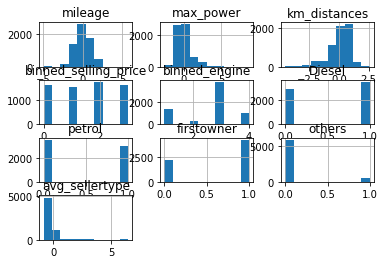

In [37]:
drop_columns = ['seats','owner',
                'seller_type','number_sold','name',
                'index', 'company', 'fuel', 'transmission', 'km_driven', 'selling_price','_seats_in_year','_company'
               ,'_num_sales','secondowner', 'co_cc', 'engine', 'year']
train.drop(columns = drop_columns, inplace=True)
test.drop(columns = drop_columns,inplace=True)
ax=train.hist()
feature_names = train.columns

In [38]:
train[train['binned_selling_price'].isna()]
#droping the na values at 2763 as it does only one class type and considered NAN
train.dropna(inplace=True)
test.dropna(inplace=True)

In [39]:
#convert into categorical if no support
train['binned_selling_price']=train['binned_selling_price'].astype('int')
test['binned_selling_price'] = test['binned_selling_price'].astype('int')
train_y = train['binned_selling_price']
test_y = test['binned_selling_price']
train.drop(columns = 'binned_selling_price', inplace =True)
test.drop(columns = 'binned_selling_price', inplace=True)

In [40]:
cols = ['Diesel', 'binned_engine', 'petrol', 'firstowner', 'others']
train[cols]=train[cols].astype('category')

In [41]:
#here train and test split have sufficent classes 
train_y_=pd.get_dummies(train_y)*1
test_y_ = pd.get_dummies(test_y)*1

In [42]:
model = LogisticRegression(4, train.shape[1], method="minibatch",batch_size=50,l2=None, num_epochs=50)
model.fit(train.values,dummies=train_y_.values, Y= train_y.values)

2024/10/06 14:45:47 INFO mlflow.tracking.fluent: Experiment with name 'Logistic_regression_st125490' does not exist. Creating a new experiment.
2024/10/06 14:45:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic_regression-staging, version 1


train loss 0.8311657663977743
valid loss 0.20726994787233113


2024/10/06 14:46:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/0de1481475d849bf9e10de63dba0c7f8.
2024/10/06 14:46:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.818046755527949
valid loss 0.21154060533542518


2024/10/06 14:46:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/6bd0f7e77bd747afb15e41e792ff8651.
2024/10/06 14:46:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8199883413584586
valid loss 0.20448427253267132


2024/10/06 14:47:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/674774dfde484f4192fa2b06e59e970f.
2024/10/06 14:47:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8214400798655951
valid loss 0.1997199900431278


2024/10/06 14:47:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-3 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/347b927738a64e3a85daa88d8c7655fb.
2024/10/06 14:47:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.814380910159533
valid loss 0.20437275106532302


2024/10/06 14:48:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-4 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/554c840d809d44eda732615b26ff203e.
2024/10/06 14:48:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.
2024/10/06 14:48:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/06 14:48:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/06 14:48:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-deer-736 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/e52c005be22747efa3645d0488995787.
2024/10/06 14:48:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac

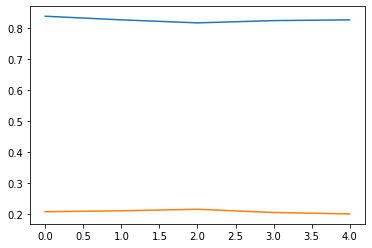

In [43]:
#test the model
#apply evaluation metrics
log_loss=model.get_train_val_prediction()
plt.plot(log_loss['train_loss'])
plt.plot(log_loss['val_loss'])

**That much variation between the training and validation because the batch losses are taken as average accrss min batches**

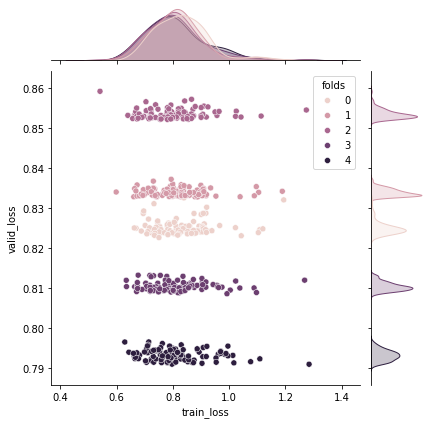

In [44]:
train_loss = list(map(lambda x:x[0], model.train_loss))
valid_loss = list(map(lambda x: x[0], model.valid_loss))
folds = list(map(lambda x: x[1], model.train_loss))
df = pd.DataFrame({'train_loss':train_loss, 'valid_loss':valid_loss, 'folds':folds})
sns.jointplot(data = df , x = 'train_loss', y='valid_loss', hue = 'folds')
#plt.xlabel('Training loss')
#plt.ylabel('Validation loss')


**losses without average after model fits, here the loss is to show the model generalisation, for instance is the training loss is 0.8 accross all the validation losse, the fold 4 is having higher value the reason to that could be because we have taken last fold assuming that model gradient stop updating for last min batch, lets analyse other metrics to see the predictive performance of the model before we deply to mlflow** 

In [45]:
pred=model.predict(test.values)
print('precision: {}'.format(precision_score(test_y.values, pred, average='macro')), 
      'recall: {}'.format(recall_score(test_y.values, pred, average='macro')))

precision: 0.5910207536534263 recall: 0.5984629161667978


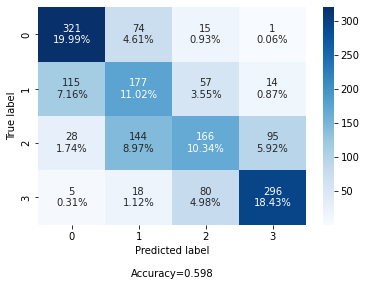

In [46]:
make_confusion_matrix(confusion_matrix(test_y.values, pred))

**what does support in the classification report means?**

In [ ]:
#task to do
#precision recall, accuracy and confusion matrix and roc-auc curve
#apply ridgem with mlflow deplyoment
#add the model the web application
#CICD


**comparision with l2 and without l2**

In [42]:
model = LogisticRegression(4, train.shape[1], method="minibatch",l2=0.01,batch_size=50, num_epochs=50)
model.fit(train.values,dummies=train_y_.values, Y= train_y.values)

train loss 0.8337017951715701
valid loss 0.2166452793236346


2024/10/09 18:25:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/6a42709c4a924a5bbc6f5988eefd31d4.
2024/10/09 18:25:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8362299619411353
valid loss 0.20584752915731544


2024/10/09 18:26:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/aa4403cbd7c540aeb6ffa905d282ca4b.
2024/10/09 18:26:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8350418442743425
valid loss 0.20213089610559418


2024/10/09 18:26:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/6d63b6386ab148e6a7cadfadb7dd65cc.
2024/10/09 18:26:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8236193654864779
valid loss 0.21001650214482398


2024/10/09 18:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-3 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/0049621a50024455be9fba216f070d5a.
2024/10/09 18:27:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8252838793804937
valid loss 0.20580441263112348


2024/10/09 18:27:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-4 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/02aeb0c1c8244148a34062091630c132.
2024/10/09 18:27:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.
2024/10/09 18:27:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/09 18:27:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/09 18:27:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-perch-46 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/c0159975d15c4ea58d6e8103d6b54511.
2024/10/09 18:27:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.

In [46]:
import pickle
pickle.dump(model, open('/home/qb/ML_Assignment_3/app/requires/logit.pkl','wb'))

In [45]:
train.columns

Index(['mileage', 'max_power', 'km_distances', 'binned_engine', 'Diesel',
       'petrol', 'firstowner', 'others', 'avg_sellertype'],
      dtype='object')

**comparison with different lr**


In [44]:
alpha = [0.01, 0.001, 0.0001]
for lr in alpha:
    model = LogisticRegression(4, train.shape[1], method="minibatch",l2=0.01, alpha = lr,batch_size=50, num_epochs=50)
    model.fit(train.values,dummies=train_y_.values, Y= train_y.values)

train loss 0.8301212758101706
valid loss 0.20875070769065449


2024/10/06 14:54:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/c8112d2a2cbb4defaca597e7b65a3393.
2024/10/06 14:54:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8248437364551596
valid loss 0.21458948896950616


2024/10/06 14:54:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/7498d32b97a142709a7e709428b7f5fb.
2024/10/06 14:54:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8321393808573966
valid loss 0.20687061816264038


2024/10/06 14:55:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/01b97f32b5c94a919587a46ad2e1a9e4.
2024/10/06 14:55:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8368806948682261
valid loss 0.20244935584344548


2024/10/06 14:55:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-3 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/001088d4487a46ce9b3eaa70475b8a21.
2024/10/06 14:55:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8302398039280667
valid loss 0.20855445581803794


2024/10/06 14:55:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-4 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/7afe1f615c374d9d9d7d1cef6f1f5ba8.
2024/10/06 14:55:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.
2024/10/06 14:55:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/06 14:56:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/06 14:56:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-chimp-305 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/4b3afd00fc3046d3a551a69d09818a96.
2024/10/06 14:56:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.

train loss 0.8322414897514985
valid loss 0.20761730064935202


2024/10/06 14:56:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/1fb5e1c94ccd459eb6223d2cdb05a719.
2024/10/06 14:56:28 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.819514794094295
valid loss 0.21164730057302894


2024/10/06 14:56:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/11f96abe06f24319ab52c72b1bd1903e.
2024/10/06 14:56:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8213735622154661
valid loss 0.20485242944519952


2024/10/06 14:57:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/5c8e1676417443e7979950d72905af67.
2024/10/06 14:57:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.822794237334718
valid loss 0.20024515594334413


2024/10/06 14:57:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-3 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/fe32eaf9d6c541959789057bd682b904.
2024/10/06 14:57:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8158947282882054
valid loss 0.20481602813254385


2024/10/06 14:58:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-4 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/7517f98fb07f4833b84f83c1a9e06df9.
2024/10/06 14:58:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.
2024/10/06 14:58:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/06 14:58:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/06 14:58:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-pig-61 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/42d1312ade5342e0b995e384a29379ef.
2024/10/06 14:58:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/ex

train loss 0.9083983494805261
valid loss 0.22706343933265985


2024/10/06 14:58:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-0 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/54b4e080d1d24aec8df679b6108834be.
2024/10/06 14:58:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8895790589353474
valid loss 0.2244124574226765


2024/10/06 14:59:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/ef813d82b759454581b77aa1c7e3ee2b.
2024/10/06 14:59:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8801201392723952
valid loss 0.22144315327507869


2024/10/06 14:59:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-2 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/9fd022fef37344d799eddba427936c81.
2024/10/06 14:59:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8772065498858087
valid loss 0.21566993300331547


2024/10/06 15:00:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-3 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/0a96db2e15ec4ee78a424a014c58fde2.
2024/10/06 15:00:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.


train loss 0.8682665867527741
valid loss 0.2179819110996848


2024/10/06 15:00:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Fold-4 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/e46d052a24544344aa1d3c9aed98bc50.
2024/10/06 15:00:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223.
2024/10/06 15:00:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/06 15:00:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/06 15:00:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-hound-382 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/335841220006519223/runs/a8bd11d9561c4ec8ad4539b021201e65.
2024/10/06 15:00:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th

**Final report**